# Dimensionality Reduction

In this project, the famous MNIST dataset will be used to perform dimensionality reduction tasks using various techniques. The mnist dataset is a set of images of handwritten digits https://en.wikipedia.org/wiki/MNIST_database. The following tasks will be carried out:

- Apply a Random Forest classification algorithm to MNIST dataset
- Perform dimensionality reduction of features using PCA and compare classification on the reduced dataset to that of original one
- Apply dimensionality reduction techniques: t-SNE and LLE

We will take advantage of GPU capability in Google colab to perform the task. 

**Set up tsnecuda**. TSNE for GPU <br>
Step 1: Change the notebook setting to GPU. Edit->notebook settings
Step 2: execute the folowing 3 cells at the beginning of the notebook. Running these in the middle of the notebook will remove all data, including mounted drive, all packages loaded, and all dataframes, ...

In [2]:
!nvidia-smi 

Fri Mar 18 01:06:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# download and unpack tsnecuda from anaconda.org
!wget https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda100.tar.bz2
!tar xvjf tsnecuda-2.1.0-cuda100.tar.bz2
!cp -r site-packages/* /usr/local/lib/python3.7/dist-packages/
# create a symbolic link between the downloaded libfaiss.so file and the location python's looking at
!echo $LD_LIBRARY_PATH 
# this is probably /usr/lib64-nvidia
!ln -s /content/lib/libfaiss.so $LD_LIBRARY_PATH/libfaiss.so

--2022-03-18 01:06:16--  https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda100.tar.bz2
Resolving anaconda.org (anaconda.org)... 104.17.93.24, 104.17.92.24, 2606:4700::6811:5d18, ...
Connecting to anaconda.org (anaconda.org)|104.17.93.24|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5d019c23c7424a015486440c/5d790a95778a870c42137059?response-content-disposition=attachment%3B%20filename%3D%22tsnecuda-2.1.0-cuda100.tar.bz2%22%3B%20filename%2A%3DUTF-8%27%27tsnecuda-2.1.0-cuda100.tar.bz2&response-content-type=application%2Fx-tar&X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Expires=60&X-Amz-Date=20220318T010616Z&X-Amz-SignedHeaders=host&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEDkaCXVzLWVhc3QtMSJHMEUCIHqhwM5vJMP%2FMbxP0fLBIv2BTIevOjTYl0SN%2B3FQjQELAiEAxv%2BgLsNcIK4%2F%2F6hTOivqtt4cBIu5r8zb7xW2llh70CUqgwQIsv%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FARAAGgw0NTU4NjQwOTgzNzgiDOmHV4UO6YvSNzSs6yrXA1YEaDq5F

In [4]:
import tsnecuda
tsnecuda.test()

**MDS for GPU**

In [59]:
 !pip install imgaug==0.2.5

     |████████████████████████████████| 562 kB 4.8 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.5-py3-none-any.whl size=561438 sha256=5d0e86ee30d7fe9467764af2533f003d5ab45d1483c56e0f4410a8564ea4042b
  Stored in directory: /root/.cache/pip/wheels/60/dd/38/d1dc2cad2b6a66dc0249261004990bccb0f27985c74ba26e49
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.7
    Uninstalling imgaug-0.2.7:
      Successfully uninstalled imgaug-0.2.7


In [60]:
!pip install mdscuda

In [61]:
from mdscuda import MDS, mds_fit, minkowski_pairs

**Mount Google drive**

In [8]:
# YOUR CODE HERE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### **Start analysis from here**

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import joblib

from sklearn.datasets import fetch_openml

In [10]:
# load the MNIST data from sklearn datasets
mnist = fetch_openml("mnist_784", version=1)

In [20]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
df = pd.DataFrame(mnist.data)
df_train = df.iloc[:60000]
df_test = df.iloc[60000:]
df_train.shape, df_test.shape

((60000, 784), (10000, 784))

In [21]:
y_train = np.array(mnist['target'].astype('str'))
y_test = np.array(mnist['target'].astype('str'))

In [22]:
feat_cols = [col for col in df.columns]

## Train a Random Forest classifier
This section we will train a random forest classiffier on the dataset and time how long it takes, then evaluate the resulting model on the test set.

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [16]:
# define scaler
def scaler(X,factor):
  return X/factor

In [17]:
# Create and fit pipeline
scaler = FunctionTransformer(func=scaler,kw_args={'factor':255.0},validate=False)
pipeline = Pipeline( [('xvar', scaler)] )
pipeline = ColumnTransformer( [('xtsfm', pipeline,feat_cols)] )

pipeline.fit(df_train)
df_train_transformed = pipeline.transform(df_train)
print(f"df_train_transformed.shape: {df_train_transformed.shape}")

df_train_transformed.shape: (60000, 784)


In [18]:
df_train_transformed_sub = df_train_transformed[:10000,:]

In [19]:
df_test_transformed = pipeline.transform(df_test)
print(f"df_test_transformed.shape: {df_test_transformed.shape}")

df_test_transformed.shape: (10000, 784)


In [12]:
# Search grid
param_grid={'n_estimators':[50],'max_depth':[10,20,50]}

In [13]:
%%time
rfc = RandomForestClassifier(random_state=10086)
rfc_cv = GridSearchCV(estimator=rfc,
                      param_grid=param_grid,
                      cv=5)
rfc_cv.fit(df_train_transformed,y_train)

CPU times: user 4min 53s, sys: 429 ms, total: 4min 53s
Wall time: 4min 59s


In [ ]:
joblib.dump(rfc_cv,r'drive/My Drive/DS4-ML/assignment3 rfc_cv.joblib')
# rfc_cv = joblib.load(r'drive/My Drive/DS4-ML/assignment3 rfc_cv.joblib')

['drive/My Drive/DS4-ML/assignment3 rfc_cv.model']

In [ ]:
rfc_cv.cv_results_

{'mean_fit_time': array([14.50694098, 20.79983811, 22.84891868]),
 'mean_score_time': array([0.25259337, 0.32964005, 0.36012964]),
 'mean_test_score': array([0.94338333, 0.96456667, 0.96533333]),
 'param_max_depth': masked_array(data=[10, 20, 50],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 50, 50],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 20, 'n_estimators': 50},
  {'max_depth': 50, 'n_estimators': 50}],
 'rank_test_score': array([3, 2, 1], dtype=int32),
 'split0_test_score': array([0.94391667, 0.96316667, 0.9645    ]),
 'split1_test_score': array([0.9455, 0.9665, 0.9665]),
 'split2_test_score': array([0.94216667, 0.96241667, 0.964     ]),
 'split3_test_score': array([0.94383333, 0.96633333, 0.96675   ]),
 'split4_test_score': array([0.9415    , 0.96441667, 0.96491667]),
 

Acccuracy score is 0.9646 when max_depth is 20 and 0.9653 when max_depth is 50. Therefore, max_depth = 20 is a good parameter.

In [ ]:
%%time
n_ests=50
max_depth=20
time0 = time.time()
rfc = RandomForestClassifier(n_estimators=n_ests,max_depth=max_depth,random_state=10086)
rfc.fit(df_train_transformed,y_train)
print(f'Time elapsed: {time.time() - time0} seconds')

Time elapsed: 23.20064926147461 seconds
CPU times: user 23.1 s, sys: 153 ms, total: 23.3 s
Wall time: 23.2 s


In [ ]:
%%time
n_ests=50
max_depth=20
time0 = time.time()
rfc = RandomForestClassifier(n_estimators=n_ests,max_depth=max_depth,random_state=10086, n_jobs=2)
rfc.fit(df_train_transformed,y_train)
print(f'Time elapsed: {time.time() - time0} seconds')

Time elapsed: 17.009568452835083 seconds
CPU times: user 32.6 s, sys: 0 ns, total: 32.6 s
Wall time: 17 s


It takes 23.5 second to complete the training task.

In [ ]:
from sklearn.metrics import classification_report

y_pred = rfc.predict(df_test_transformed)

print(f'Classification report:')
pd.DataFrame(classification_report(y_test,y_pred,output_dict=True)).transpose()

Classification report:


,precision,recall,f1-score,support
0,0.983264,0.980188,0.981723,959.0000
1,0.982788,0.988745,0.985757,1155.0000
2,0.958580,0.965243,0.961900,1007.0000
3,0.953398,0.945140,0.949251,1039.0000
4,0.969631,0.966486,0.968056,925.0000
5,0.971429,0.959826,0.965593,921.0000
6,0.975585,0.986626,0.981074,972.0000
7,0.962229,0.972328,0.967252,1048.0000
8,0.944964,0.954879,0.949896,953.0000
9,0.954046,0.935357,0.944609,1021.0000


With 96.6% of classification accuracy, and on average96.6% macro and weighted average f1_score.

## PCA for dimensionality reduction 
In this section, we will use PCA to reduce the dataset’s dimensionality, with an explained variance ratio of 95%. Train a new Random Forest classifier on the reduced dataset and evaluate the result. We will time the training process and see how long it takes.

### PCA on original data

In [28]:
# YOUR CODE HERE
from sklearn.decomposition import PCA
import time

In [29]:
time0 = time.time()
pca = PCA(n_components = 0.95, random_state=10068)
pca_reduced_res = pca.fit_transform(df_train_transformed)
print(f'Time elapsed: {time.time() - time0} seconds')

Time elapsed: 12.029643297195435 seconds


In [45]:
# Map the test set onto the dimensionality reduced space
df_test_reduced = pca.transform(df_test_transformed)
df_test_reduced

array([[-2.25462495e+00,  1.96336194e+00,  4.76192671e-02, ...,
         1.97759947e-02,  3.95322051e-02, -7.98767768e-02],
       [ 3.50941501e-01, -3.33961198e+00,  1.51137415e+00, ...,
         1.50321733e-03,  3.30870358e-01, -2.00640554e-01],
       [-1.21899579e+00,  1.00185037e+00,  2.01374684e+00, ...,
         2.46204709e-01,  3.99783023e-01, -2.50111770e-01],
       ...,
       [-2.96345888e-01,  3.84409216e+00, -5.24564726e-01, ...,
         7.73233276e-02, -4.42126569e-03, -2.05468785e-01],
       [-4.12842451e-01, -1.42018031e+00,  2.04411194e+00, ...,
        -2.12717855e-01, -2.63698662e-01,  3.00357533e-01],
       [-1.90206683e+00,  1.30083999e+00,  1.14916518e+00, ...,
         6.79753714e-02,  6.19836575e-02, -7.55415327e-02]])

154 principal components captured 95% of the variance in the training set.<br>
Now let's use random forest classifier on the reduced set.

### Random Forest Classifier on PCA reduced data

In [ ]:
%%time
time0 = time.time()
rfc_pca = RandomForestClassifier(n_estimators=n_ests,max_depth=max_depth, random_state=10086)
rfc_pca_res = rfc_pca.fit(pca_reduced_res, y_train)
print(f'Time elapsed: {time.time()-time0} seconds')

Time elapsed: 55.89536380767822 seconds
CPU times: user 55.8 s, sys: 103 ms, total: 55.9 s
Wall time: 55.9 s


In [ ]:
%%time
time0 = time.time()
rfc_pca = RandomForestClassifier(n_estimators=n_ests,max_depth=max_depth, random_state=10086, n_jobs=2)
rfc_pca.fit(pca_reduced_res, y_train)
print(f'Time elapsed: {time.time()-time0} seconds')

Time elapsed: 60.66874551773071 seconds
CPU times: user 1min 18s, sys: 1.74 ms, total: 1min 18s
Wall time: 1min


In [ ]:
y_pred_rfc_pca = rfc_pca.predict(df_test_reduced)

In [ ]:
print(f'Random forest classifier classification report:')
pd.DataFrame(classification_report(y_test, y_pred_rfc_pca,output_dict=True,)).T

Random forest classifier classification report:


,precision,recall,f1-score,support
0,0.972746,0.967675,0.970204,959.0000
1,0.982729,0.985281,0.984003,1155.0000
2,0.944223,0.941410,0.942815,1007.0000
3,0.911932,0.926853,0.919332,1039.0000
4,0.927597,0.955676,0.941427,925.0000
5,0.935939,0.935939,0.935939,921.0000
6,0.961460,0.975309,0.968335,972.0000
7,0.949331,0.947519,0.948424,1048.0000
8,0.926124,0.907660,0.916799,953.0000
9,0.931174,0.901077,0.915879,1021.0000


***Accuracy reduced slightly to 94.5% from 96.6%*** using original features. However, the ***time it takes increased significantly (more than doubled)***. <br>
Let's analyze the two models to see what is the reason rfc_pca took longer time.

### Analyze the complexity of models rfc and rfc_pca

In [ ]:
def analyze_RF(rf): #visualize the distribution of random forest hyperparameters
  list_DT = rf.estimators_
  df_hyperparam = pd.DataFrame({"depth":[DT.get_depth() for DT in list_DT], "n_leaves":[DT.get_n_leaves() for DT in list_DT]})
  df_hyperparam.plot.hist(subplots=True, legend=True, layout=(1, 2), figsize=(15,7))
  df_hyperparam.index.name = "Tree"
  # display(df_hyperparam)

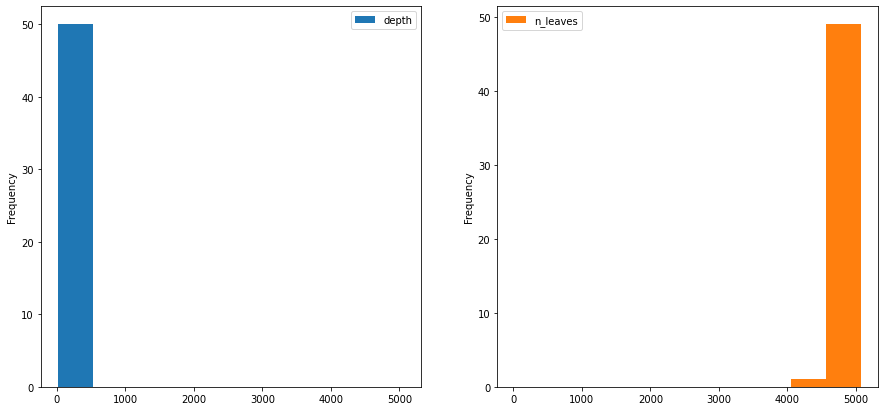

In [ ]:
analyze_RF(rfc)

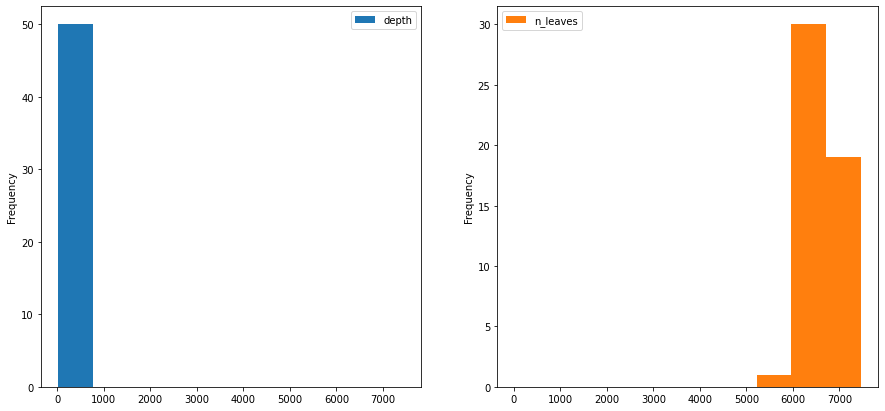

In [ ]:
analyze_RF(rfc_pca)

It seems that the model's complexity is similar to each other.


A possible ***explanation*** is, based on https://towardsdatascience.com/decision-tree-overview-with-no-maths-66b256281e2b, that 
*Random Forest (same with decision tree) is sensitive to the rotation of the data, and maybe PCA is also making the data rotated in a way that's difficult for the decision tree algorithm to draw the decision boundaries*.<br>
***Another reason*** may be related to the RandomForestClassifier algorithm' optimization strategy. *While fitting, the algorithm is iterating over possible splits that optimize the criterion. However, by reducing the number of features you might have made the problem to find this splits more difficult (by having less good splits to find), which makes the algorithm need more iterations to find a good split.* <br>
***The third reason*** may be related to the difference in number of max_features. *In the models, max_features is set default value "auto", which means the max_feature is sqrt of the number of features. For the rfc model, the number of features is 784, so max_features=sqrt(784)=28, while for rfs_pca model, this max_features=sqtr(154)=12. So the reduction is not as dramatic.* <br>
the last two reasons are based on the stackoverflow post https://stackoverflow.com/a/51581373.


### Use t-SNE for dimensional reduction and visualization
In this section, we will use t-SNE to reduce the MNIST dataset, and show result graphically.

#### ***TSNE using GPU***

In [32]:
%%time
time0 = time.time()
tsnecuda_reducer = tsnecuda.TSNE(n_components=2)
tsnecuda_reduced = tsnecuda_reducer.fit_transform(df_train_transformed)

print(f'Time elapsed: {time.time() - time0} seconds')
display(tsnecuda_reduced.shape)

Time elapsed: 19.591609239578247 seconds


(60000, 2)

CPU times: user 19 s, sys: 427 ms, total: 19.4 s
Wall time: 19.6 s


In [30]:
%%time
time0 = time.time()
tsnecuda_pca_reducer = tsnecuda.TSNE(n_components=2)
tsnecuda_pca_reduced = tsnecuda_pca_reducer.fit_transform(pca_reduced_res)

print(f'Time elapsed: {time.time() - time0} seconds')
display(tsnecuda_pca_reduced.shape)

Time elapsed: 6.539885997772217 seconds


(60000, 2)

CPU times: user 5.91 s, sys: 491 ms, total: 6.4 s
Wall time: 6.55 s


Text(0.5, 1.0, 'PCA + TSNE')

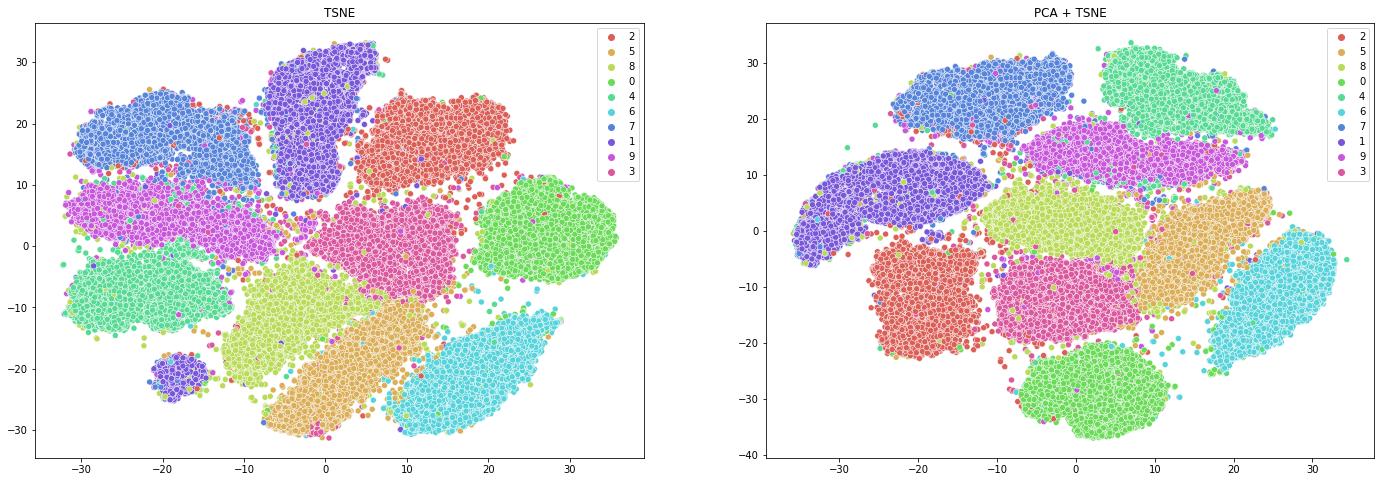

In [33]:
# Visualization
plt.figure(figsize=(24,8))
ax1 = plt.subplot(121)
sns.scatterplot(x=tsnecuda_reduced[:,0], y=tsnecuda_reduced[:,1],
                hue=y_train, palette=sns.color_palette('hls',10),
                ax=ax1).set_title("TSNE")

ax2 = plt.subplot(122)
sns.scatterplot(x=tsnecuda_pca_reduced[:,0], y=tsnecuda_pca_reduced[:,1],
                hue=y_train, palette=sns.color_palette('hls',10),
                ax=ax2).set_title("PCA + TSNE")

TSNE fo GPU is much faster (1/3 of total time) on PCA reduced data than on original data. Also it seems TSNE on original features has an additional small cluster of digit 1, while PCA + TSNE does not.

#### ***TSNE from sklearn.manifold***

In [ ]:
from sklearn.manifold import TSNE

time0 = time.time()

tsne_reducer = TSNE(n_components=2)
tsne_res = tsne_reducer.fit_transform(df_train_transformed)

print(f'Time elapsed: {time.time() - time0} seconds')
tsne_res.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Time elapsed: 1374.7302553653717 seconds


(60000, 2)

In [39]:
# joblib.dump(tsne_reducer,r'drive/My Drive/DS4-ML/assignment3 tsne_reducer_mnist.model')
joblib.load(r'drive/My Drive/DS4-ML/tsne_reducer_mnist.model')

TSNE()

In [ ]:
# on pca reduced data
time0 = time.time()

tsne_pca_reducer = TSNE(n_components=2)
tsne_pca_res = tsne_pca_reducer.fit_transform(pca_reduced_res)

print(f'Time elapsed: {time.time() - time0} seconds')
tsne_pca_res.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Time elapsed: 1031.8191726207733 seconds


(60000, 2)

The time it took for tsne from the sklearn manifold class was about 1375 seconds (about 23 minutes) using original dataset, and it reduced to 1032 seconds (about 17 minutes) when using dimensionality reduced dataset.

In [35]:
joblib.dump(tsne_pca_reducer,r'drive/My Drive/DS4-ML/assignment3 tsne_pca_reducer_mnist.model')
# joblib.load(r'drive/My Drive/DS4-ML/assignment3 tsne_pca_reducer_mnist.model')

TSNE()

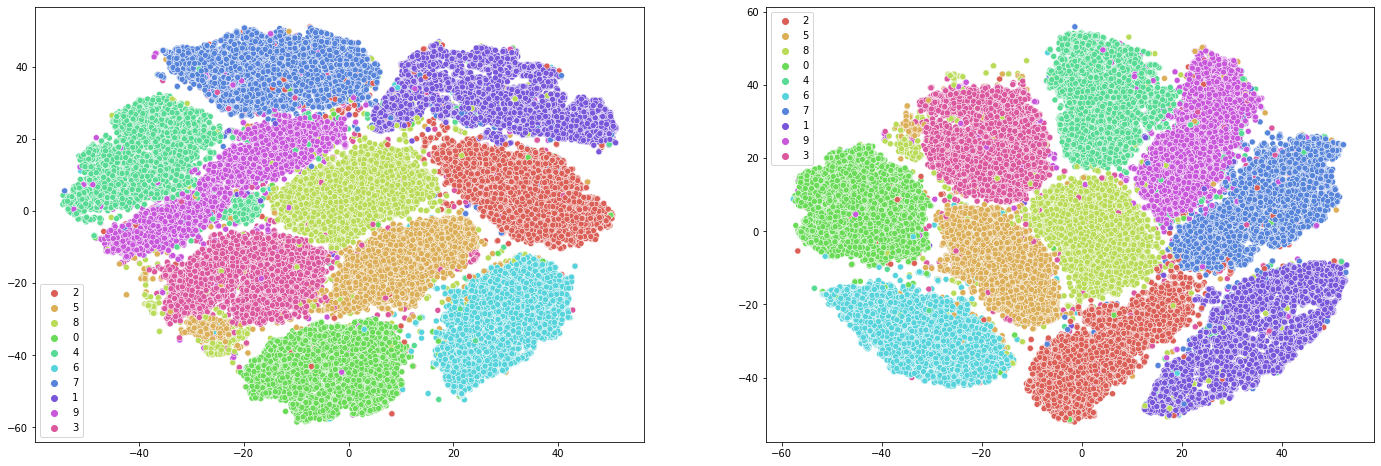

In [ ]:
plt.figure(figsize=(24,8))
ax1 = plt.subplot(121)
sns.scatterplot(x=tsne_res[:,0], y=tsne_res[:,1],
                hue=y_train, palette=sns.color_palette('hls',10),
                ax=ax1)

ax2 = plt.subplot(122)
sns.scatterplot(x=tsne_pca_res[:,0], y=tsne_pca_res[:,1],
                hue=y_train, palette=sns.color_palette('hls',10),
                ax=ax2)

It seems some 3s, 5s and 8s mixed up. Also some scatter mis-classification.

## Locally Linear Embedding (LLE) and Multidimensional scaling (MDS) 
Compare with other dimensionality methods: _Locally Linear Embedding_ (LLE) or _Multidimensional scaling_ (MDS).

### ***LLE method***

Use a subset of samples so that LLE won't crash.

In [49]:
from sklearn.manifold import LocallyLinearEmbedding

In [21]:
df_train_transformed_sub=df_train_transformed[:10000,]

In [44]:
time0 = time.time()
lle_reducer = LocallyLinearEmbedding(n_neighbors=10, n_components=2, n_jobs=-1,random_state=10086)
lle_res = lle_reducer.fit_transform(df_train_transformed_sub)
print(f'Time elapsed: {time.time()-time0} seconds')

Time elapsed: 71.8898503780365 seconds


In [45]:
joblib.dump(lle_reducer,r'drive/My Drive/DS4-ML/assignment3 LLE reducer_mnist.10000inst.joblib')
# lle_reducer = joblib.load(r'drive/My Drive/DS4-ML/assignment3 LLE reducer_mnist.10000inst.joblib')

['drive/My Drive/DS4-ML/assignment3 LLE reducer_mnist.10000inst.joblib']

In [47]:
pca_sub = PCA(n_components=0.95,random_state=10086)
pca_reduced_sub_res = pca_sub.fit_transform(df_train_transformed_sub)
pca_reduced_sub_test = pca_sub.transform(df_test_transformed)

In [50]:
# LLE on pca_reduced 
time0 = time.time()
lle_pca_reducer = LocallyLinearEmbedding(n_neighbors=10, n_components=2, n_jobs=-1,random_state=10086)
lle_pca_res = lle_pca_reducer.fit_transform(pca_reduced_sub_res)

joblib.dump(lle_pca_reducer,r'drive/My Drive/DS4-ML/assignment3 LLE pca reducer_mnist.10000inst.joblib')
print(f'Time elapsed: {time.time()-time0} seconds')

Time elapsed: 105.80646705627441 seconds


In [51]:
joblib.dump(lle_pca_reducer,r'drive/My Drive/DS4-ML/assignment3 LLE pca reducer_mnist.10000inst.joblib')
# lle_pca_reducer = joblib.load(r'drive/My Drive/DS4-ML/assignment3 LLE pca reducer_mnist.10000inst.joblib')

['drive/My Drive/DS4-ML/assignment3 LLE pca reducer_mnist.10000inst.joblib']

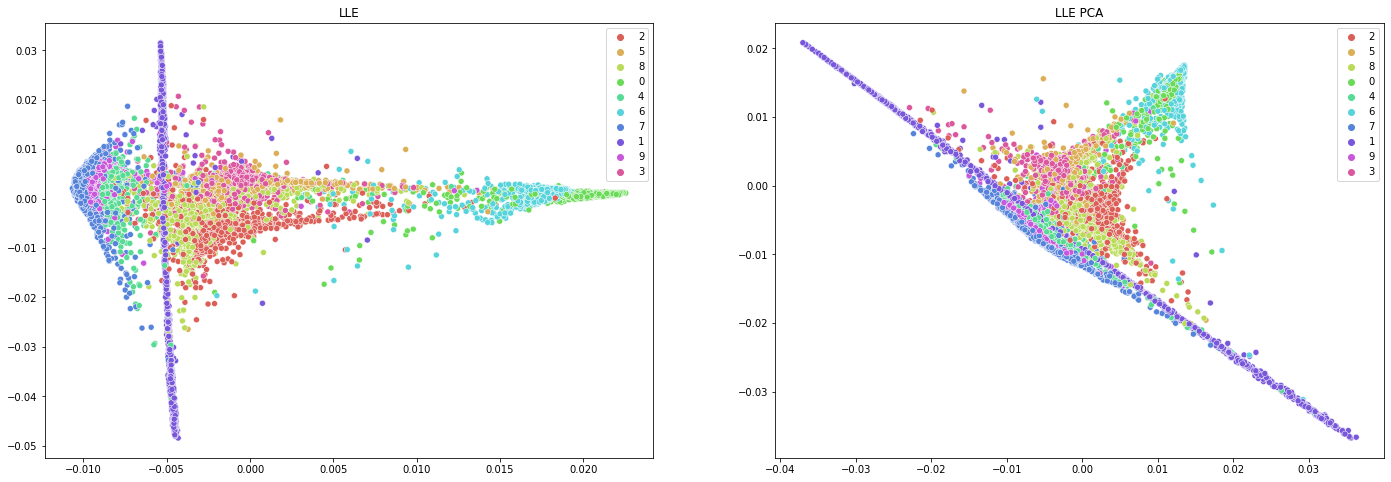

In [57]:
plt.figure(figsize=(24,8))
ax1 = plt.subplot(121)
sns.scatterplot(x=lle_res[:,0], y=lle_res[:,1], hue=y_train[:10000], 
                palette=sns.color_palette('hls',10),
                ax=ax1
                ).set_title('LLE')

ax2 = plt.subplot(122)
sns.scatterplot(x=lle_pca_res[:,0], y=lle_pca_res[:,1], hue=y_train[:10000],
                palette=sns.color_palette('hls',10),
                ax=ax2
                ).set_title('LLE PCA');

Execution time is slightly longer than that of using original features. The PCA reduced dataset is rotated. <br>
The graphs suggest the examples are grouped together. The LLE method is not as good as t-SNE in finding the structure of the mnist data. <br>
There seem no clear relationships between the first and second compnents from the LLE dimension reduction algorithm.

***Comparing on the test set***

In [39]:
lle_reducer = joblib.load(r'drive/My Drive/DS4-ML/assignment3 LLE reducer_mnist.10000inst.joblib')
lle_pred = lle_reducer.transform(df_test_transformed)
lle_pred.shape

(10000, 2)

In [54]:
lle_pca_reducer = joblib.load(r'drive/My Drive/DS4-ML/assignment3 LLE pca reducer_mnist.10000inst.joblib')
lle_pca_test = lle_pca_reducer.transform(pca_reduced_sub_test)
lle_pca_test.shape

(10000, 2)

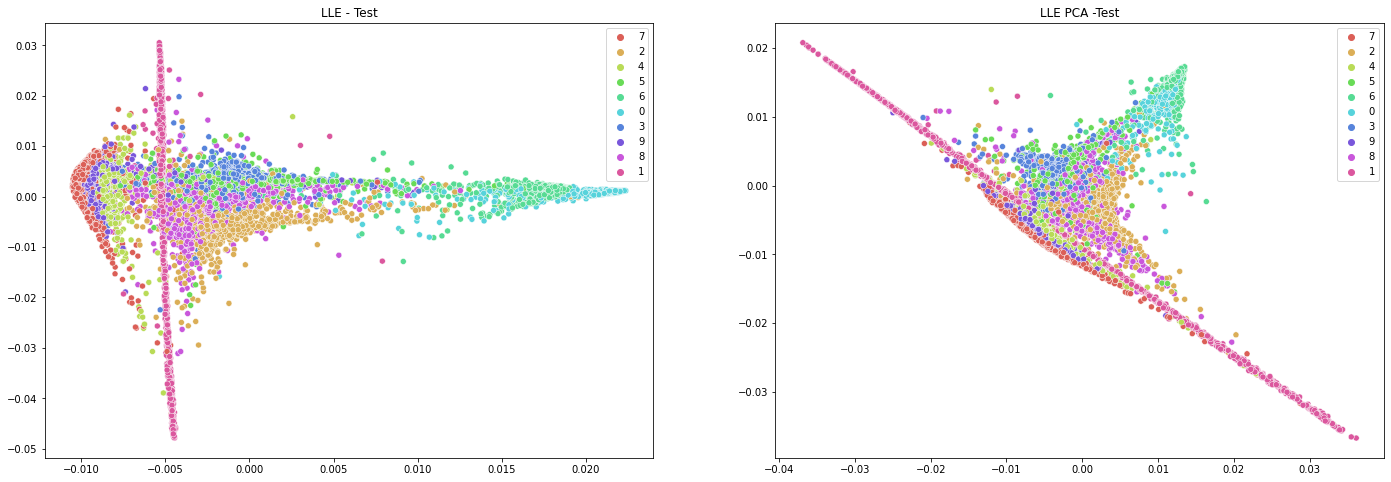

In [56]:
plt.figure(figsize=(24,8))
ax1 = plt.subplot(121)
sns.scatterplot(x=lle_test[:,0], y=lle_test[:,1], hue=y_test[:10000], 
                palette=sns.color_palette('hls',10),
                ax=ax1
                ).set_title('LLE - Test')

ax2 = plt.subplot(122)
sns.scatterplot(x=lle_pca_test[:,0], y=lle_pca_test[:,1], hue=y_test[:10000],
                palette=sns.color_palette('hls',10),
                ax=ax2
                ).set_title('LLE PCA -Test');

Results on the test dataset are similar to that on the training set.

#### ***MDS method***

In [20]:
from sklearn.manifold import MDS

In [21]:
%%time
time0 = time.time()
mds_reducer = MDS(n_components=2)
mds_res = mds_reducer.fit_transform(df_train_transformed_sub)
print(f'Time elapsed: {time.time() - time0} seconds')
joblib.dump(mds_reducer,r'drive/My Drive/DS4-ML/assignment3 mds reducer_mnist.10000inst.joblib')
mds_res.shape

Time elapsed: 3060.954553604126 seconds
CPU times: user 57min 13s, sys: 2min 36s, total: 59min 50s
Wall time: 51min 3s


In [21]:
mds_reducer = joblib.load(r'drive/My Drive/DS4-ML/assignment3 mds reducer_mnist.10000inst.joblib')

In [23]:
mds_reducer.embedding_.shape

(10000, 2)

In [69]:
# Using MDS for GPU
from mdscuda import MDS, mds_fit, minkowski_pairs
time0 = time.time()
mdscuda_reducer = mds_fit(minkowski_pairs(df_train_transformed_sub, sqform=False), n_dims=2)
joblib.dump(mdscuda_reducer,r'drive/My Drive/DS4-ML/assignment3 mdscuda reducer_mnist.10000inst.joblib')
print(f'Time elapsed: {time.time() -time0} seconds')
display(mdscuda_reducer.shape)

Time elapsed: 93.40290832519531 seconds


(10000, 2)

Using MDS for GPU is much much faster then using MDS from Scikit Learn's manifold class for the same dataset. However, it is not possible to fit the whole training set.

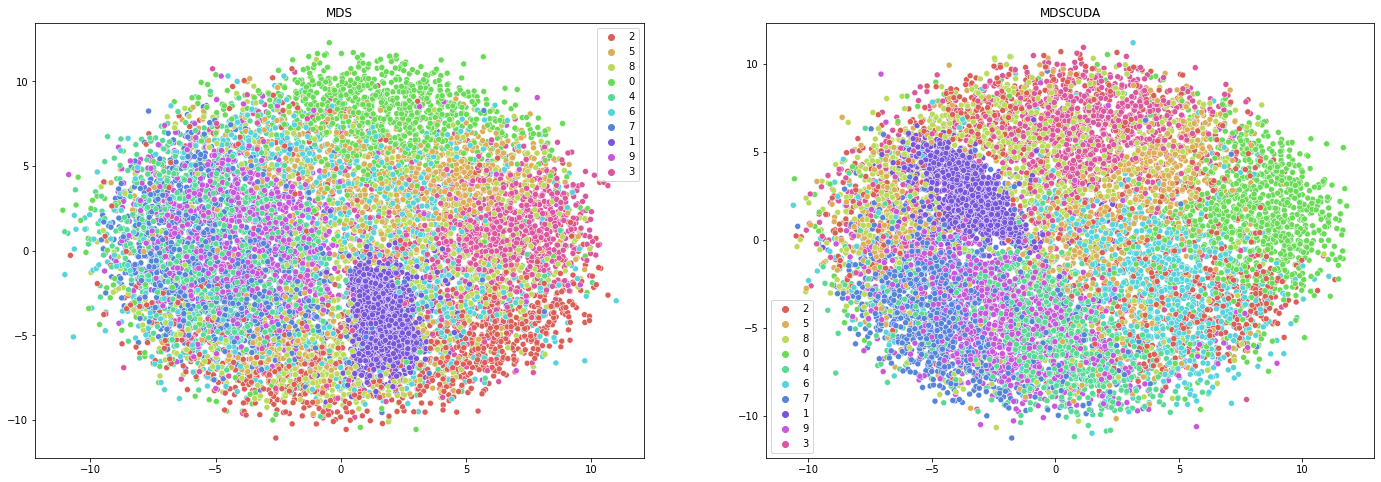

In [73]:
plt.figure(figsize=(24,8))
ax1 = plt.subplot(121)
sns.scatterplot(x=mds_reducer.embedding_[:,0], y=mds_reducer.embedding_[:,1],
                hue=y_train[:10000], palette=sns.color_palette('hls',10),
                ax=ax1
                ).set_title('MDS')

ax2 = plt.subplot(122)
sns.scatterplot(x=mdscuda_reducer[:,0], y=mdscuda_reducer[:,1],
                hue=y_train[:10000], palette=sns.color_palette('hls',10),
                ax=ax2
                ).set_title('MDSCUDA');

MDS algorithm is not as good as t-SNE for the mnist dataset in revealing the structure of the data. It seems digits 0 and 4 can be seaparated better than other digists using either Manifold MDS or MDS for GPU (MDSCUDA).

### **Conclusions**

1) Although PCA + RFC is slower than RFC only, if the model's CV score is good, it is a useful model. one major benefit of PCA is to reduce the dimensionality of your data, so the data can fit in your computer's memory. Even if the new data are slower to calculate for RF, it still is an improvement compared to not being able to fit RF on your original data at all.<br><br>
2) TSNE from scikit learn' manifold is way much slower than the TSNE for GPU (tsnecude). The latter requires hardware GPU.<br><br>
3) Also LLE is very slow. Using full dataset caused run out of RAM and crashes on Google Colab. I had to reduce the number of the examples to 1/6 of original 60,000 examples in order for this assignment to complete.<br><br>
4) MDS method from scikit learn's manifold is also very very slow and had to use subset of examples. Somehow mdscuda is not working, after fixing the problem at installation (downgrading imguage to 0.2.5), it causes out-of-memory error. I had to use a subset of data (10000 examples).